In [ ]:
## based on 2_training and 3_prediction from StarDist

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available,_draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.
/home/trasse/anaconda3/envs/opsef004/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/trasse/anaconda3/envs/opsef004/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/trasse/anaconda3/envs/opsef004/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/trasse/a

# Data

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
# define location of data
trainModelSettings = {}
trainModelSettings["root"] = "/mnt/ag-microscopy/SampleDataML/forOpsef_Final/GT/SD_dsb2018"
trainModelSettings["basedir_StarDist_Train"] = "./models"
trainModelSettings["name"] = 'Test_Train'
trainModelSettings["nrays"] = 32
trainModelSettings["epochs"] = 20
trainModelSettings["steps_per_epoch"] = 100

In [3]:
X = sorted(glob('{}/train/images/*.tif'.format(trainModelSettings["root"])))
Y = sorted(glob('{}/train/masks/*.tif'.format(trainModelSettings["root"])))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:02<00:00, 191.98it/s]


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


Training data consists of pairs of input image and label instances.

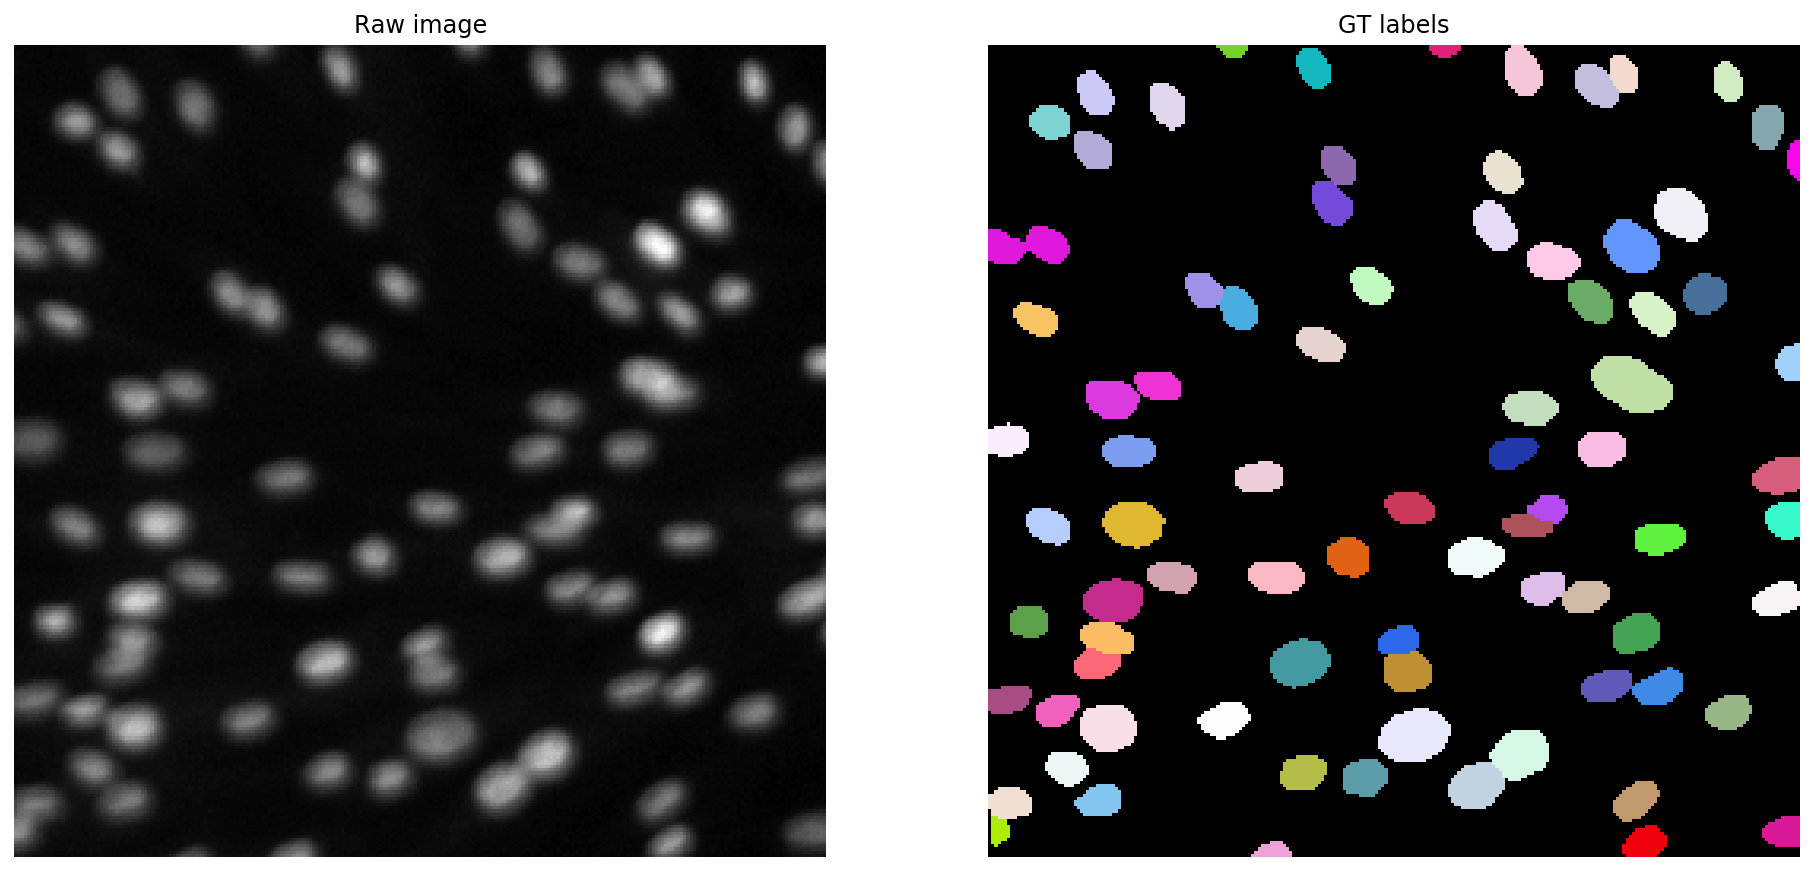

In [7]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [8]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [9]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = trainModelSettings["nrays"]

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [11]:
model = StarDist2D(conf, name=trainModelSettings["name"], basedir = trainModelSettings["basedir_StarDist_Train"])

/home/trasse/anaconda3/envs/opsef004/lib/python3.6/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/trasse/github/OpSeF-IV/Train/TrainStarDist/models/Test_Train
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.46493, nms_thresh=0.3.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [12]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

# Training

You can define a function/callable that applies augmentation to each batch of the data generator.

In [13]:
augmenter = None

# def augmenter(x, y):
#     """Augmentation of a single input/label image pair.
#     x is an input image
#     y is the corresponding ground-truth label image
#     """
#     # modify a copy of x and/or y...
#     return x, y

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [14]:
 model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=trainModelSettings["epochs"] , steps_per_epoch=trainModelSettings["steps_per_epoch"])

Epoch 1/20
100/100 [==============================] - 9s 89ms/step - loss: 2.3696 - prob_loss: 0.3729 - dist_loss: 9.9834 - prob_kld: 0.2977 - dist_relevant_mae: 9.9829 - dist_relevant_mse: 194.1107 - val_loss: 1.7119 - val_prob_loss: 0.3309 - val_dist_loss: 6.9048 - val_prob_kld: 0.2645 - val_dist_relevant_mae: 6.9041 - val_dist_relevant_mse: 101.8750
Epoch 2/20
100/100 [==============================] - 5s 51ms/step - loss: 1.4980 - prob_loss: 0.2334 - dist_loss: 6.3227 - prob_kld: 0.1601 - dist_relevant_mae: 6.3219 - dist_relevant_mse: 85.1510 - val_loss: 1.3236 - val_prob_loss: 0.0939 - val_dist_loss: 6.1485 - val_prob_kld: 0.0275 - val_dist_relevant_mae: 6.1475 - val_dist_relevant_mse: 76.1919
Epoch 3/20
100/100 [==============================] - 5s 54ms/step - loss: 1.2156 - prob_loss: 0.1082 - dist_loss: 5.5367 - prob_kld: 0.0346 - dist_relevant_mae: 5.5359 - dist_relevant_mse: 68.3447 - val_loss: 1.0377 - val_prob_loss: 0.0952 - val_dist_loss: 4.7122 - val_prob_kld: 0.0288 - va

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [15]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:32<00:10,  2.15s/it, 0.530 -> 0.699]


Using optimized values: prob_thresh=0.486541, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.48654108158464726, 'nms': 0.3}

# Data

We now load images from the sub-folder `test` that have not been used during training.

In [18]:
X = sorted(glob('{}/test/images/*.tif'.format(trainModelSettings["root"])))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [19]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [20]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

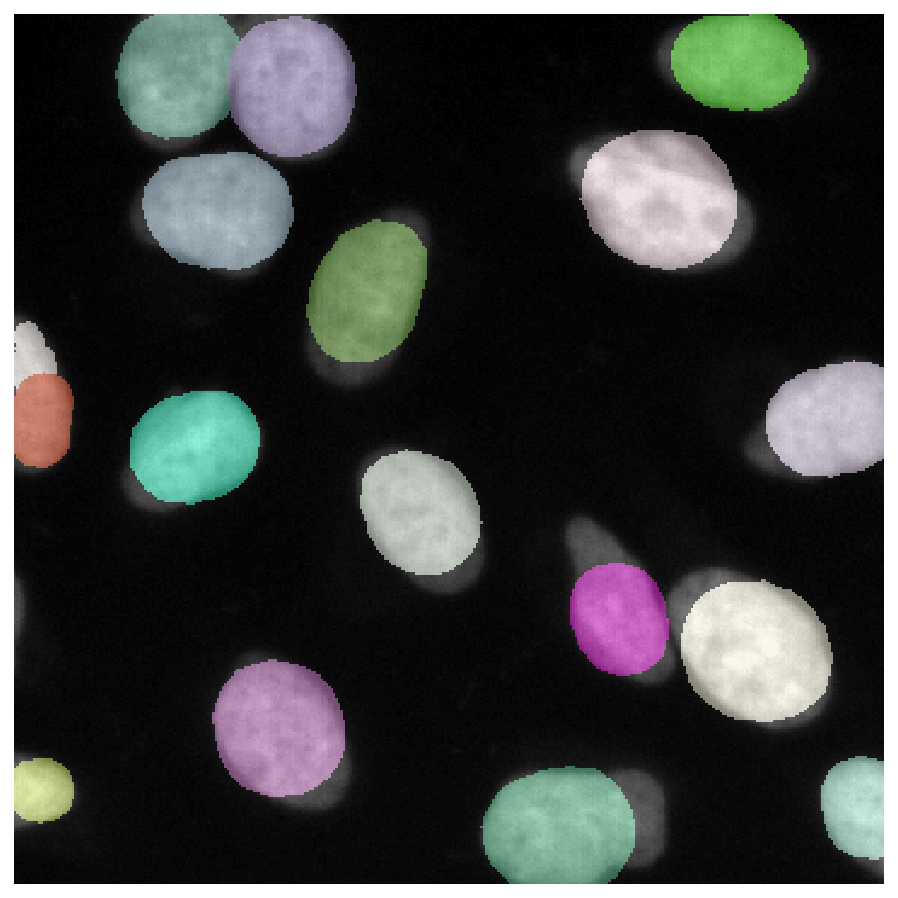

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [24]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

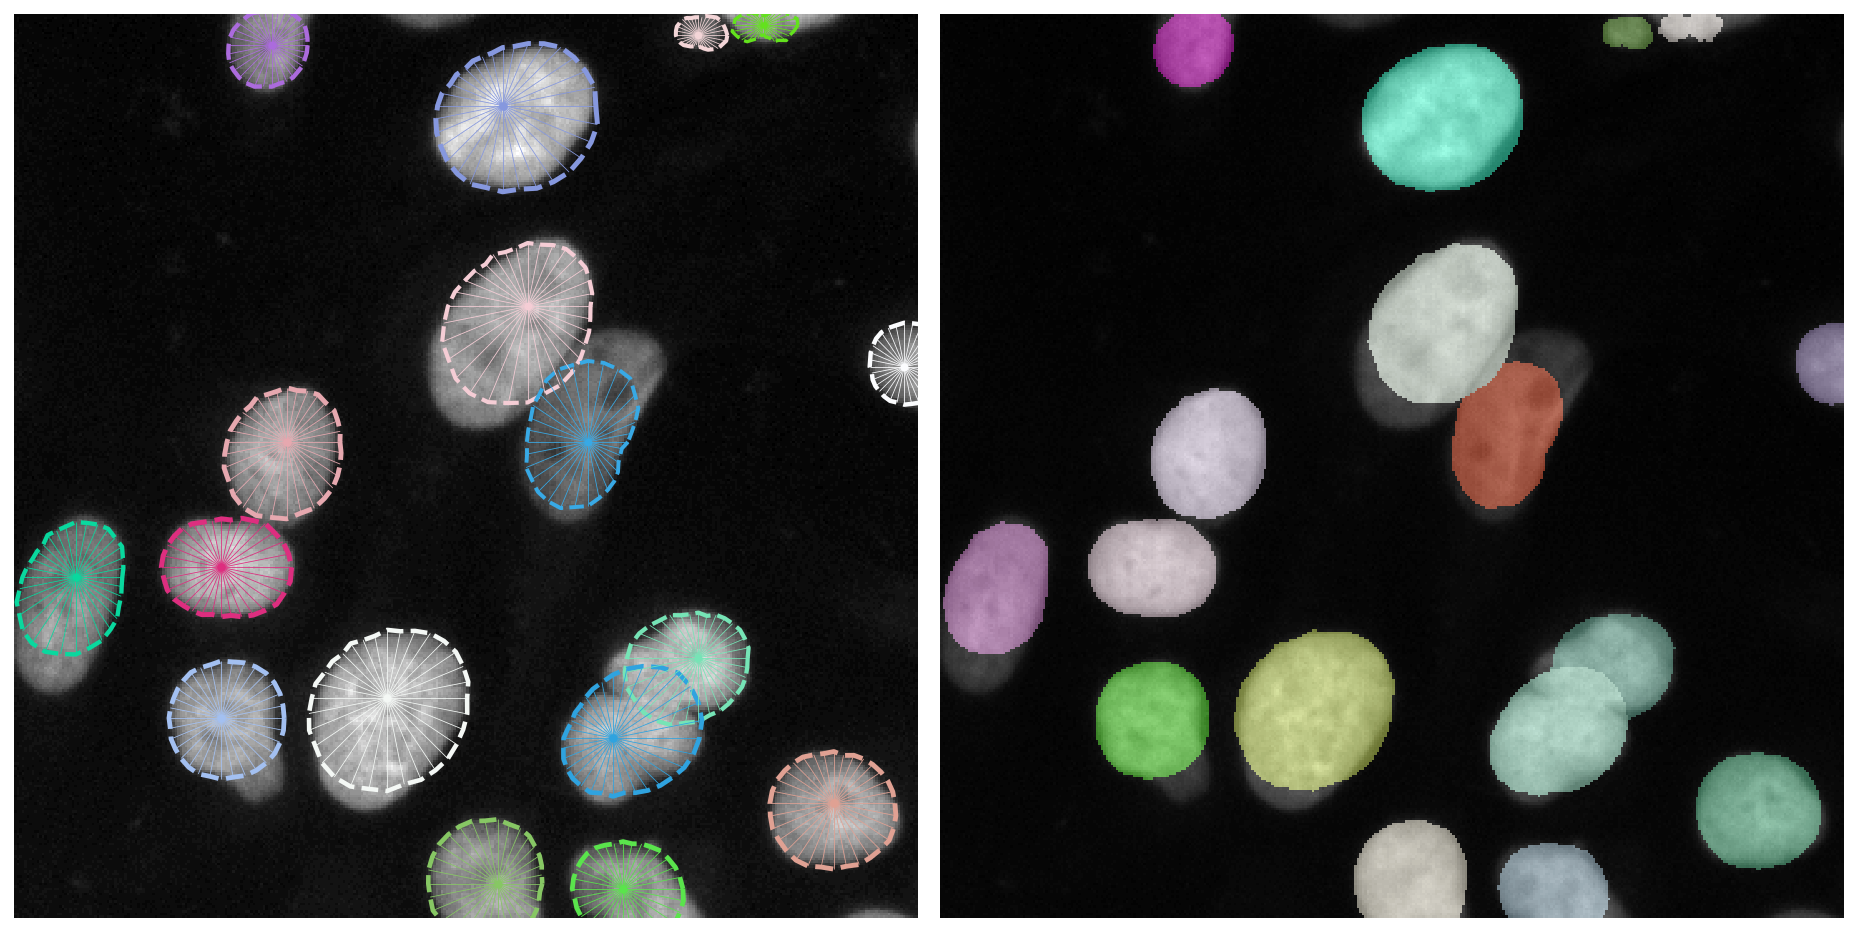

In [27]:
example(model, 42)

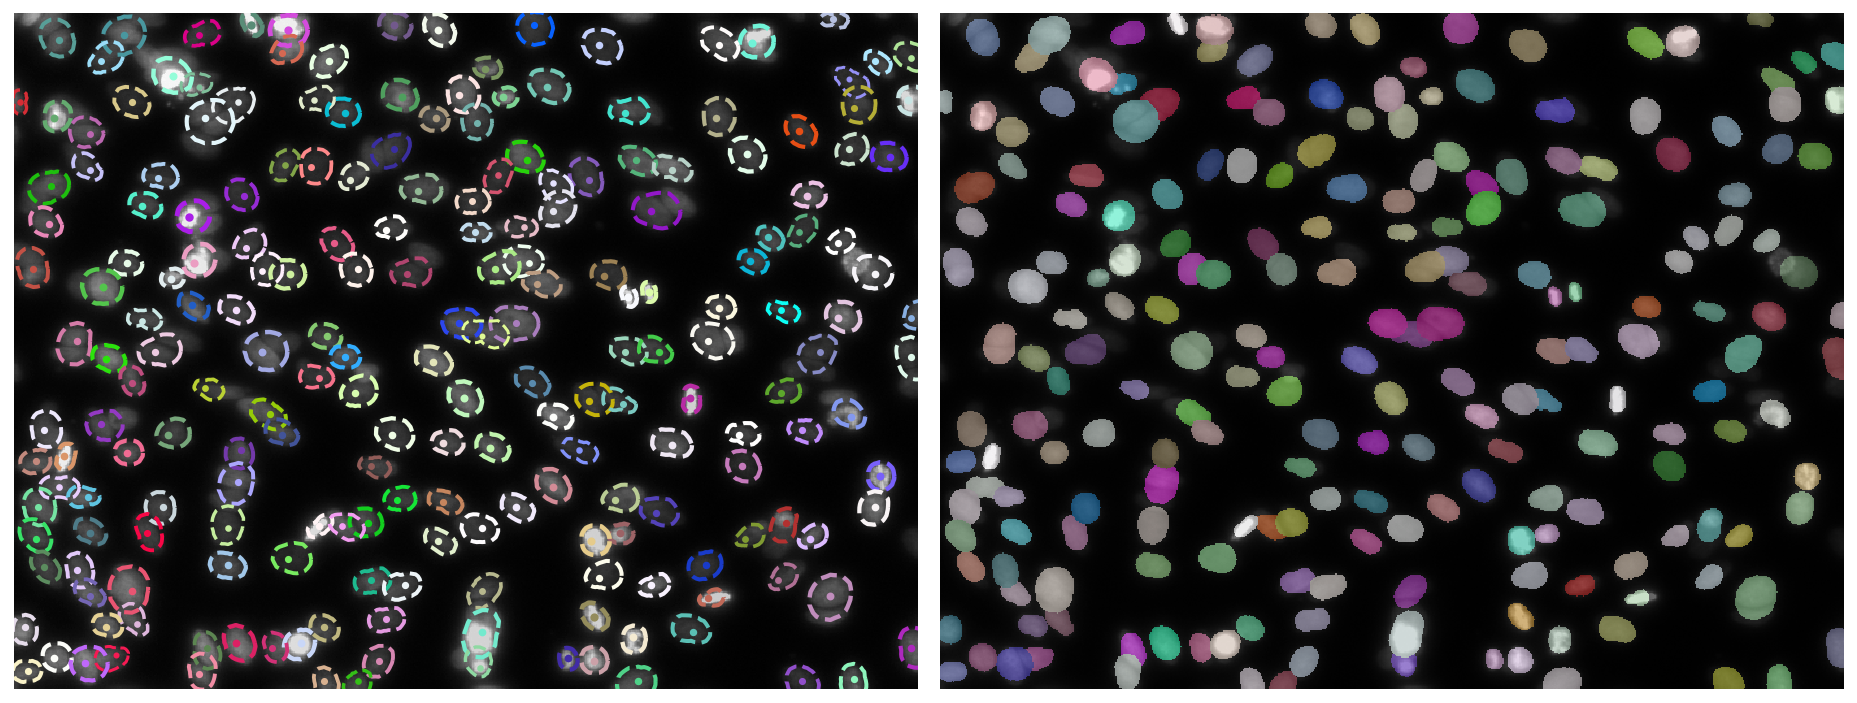

In [28]:
example(model, 15, False)